In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'unet_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip
# ! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
# data_distribution_count = pd.Series(
#     {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

# data_distribution_count

In [ ]:
# fig, axis = plt.subplots(figsize=(13, 5))
# axis.grid(True, alpha=0.1)
# axis.set_title("Data Distribution Percentage (%)", fontsize=14)
# sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
#             y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
# axis.set_xlabel("Tumor Class", fontsize=12)
# axis.set_ylabel("% Total Observations", fontsize=12)
# axis.tick_params(which='major', labelsize=12)
# axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
# sns.despine()

# Preprocess Data


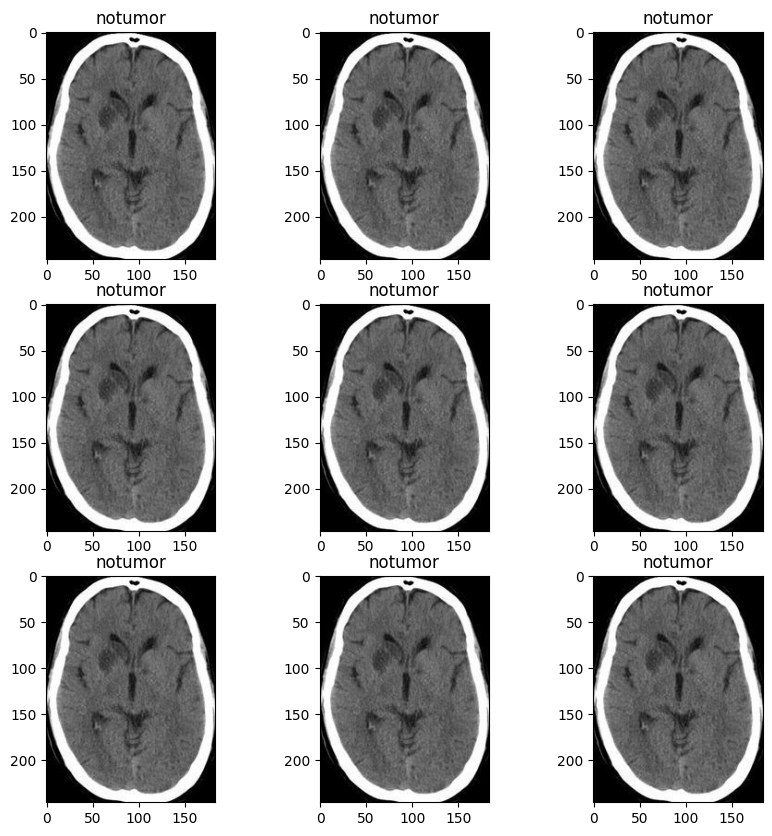

In [5]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

In [6]:
!pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
from keras.optimizers import *
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import keras

# Define the classes (replace 'dir' with the path to your dataset directory)
classes = os.listdir("dataset_19/")

# Define the create_model function with new hyperparameters
def create_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Downsampling (encoder)
    conv1 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(inputs)
    conv1 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    drop1 = Dropout(0.11651185832912539)(pool1)

    conv2 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(drop1)
    conv2 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    drop2 = Dropout(0.1846901637386165)(pool2)

    conv3 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(drop2)
    conv3 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    drop3 = Dropout(0.06166659840356162)(pool3)

    conv4 = Conv2D(140, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(pool3)
    drop4 = Dropout(0.37681312887541973)(conv4)
    batch4 = BatchNormalization()(drop4)

    # Upsampling (decoder)
    up5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch4))
    merge5 = concatenate([batch3, up5], axis=3)
    conv5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge5)
    conv5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv5)
    batch5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.21896201850969294)(batch5)

    up6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch5))
    merge6 = concatenate([batch2, up6], axis=3)
    conv6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge6)
    conv6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv6)
    batch6 = BatchNormalization()(conv6)
    drop6 = Dropout(0.14780627136149532)(batch6)

    up7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch6))
    merge7 = concatenate([batch1, up7], axis=3)
    conv7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge7)
    conv7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv7)
    batch7 = BatchNormalization()(conv7)
    drop7 = Dropout(0.24722972858230038)(batch7)
    conv7 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(batch7)

    # Output layer
    flatten = Flatten()(conv7)
    output = Dense(num_classes, activation='softmax')(flatten)

    model = Model(inputs=inputs, outputs=output)
    # model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

def objective(trial):
    # Hyperparameters to tune

    # Suggest optimizer (Adam, RMSprop, SGD, etc.)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Nadam', 'Adadelta', 'Adagrad', 'Adamax'])
    optimizer = {
        'Adam': Adam,
        'RMSprop': RMSprop,
        'SGD': SGD,
        'Nadam': Nadam,
        'Adadelta': Adadelta,
        'Adagrad': Adagrad,
        'Adamax': Adamax
    }[optimizer_name]
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)

    # Suggest loss function
    loss_function = trial.suggest_categorical('loss_function', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])

    # Suggest batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create and compile the model with the given hyperparameters
    model = create_model((128, 128, 3), len(classes))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])


    # Define data generators with dynamic batch size
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
        rotation_range=20,
        validation_split=0.2
    )

    validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        "dataset_19/",
        target_size=(128, 128),
        batch_size=batch_size,
        seed=42,
        subset='training'
    )

    test_generator = validation_datagen.flow_from_directory(
        "dataset_19/",
        target_size=(128, 128),
        batch_size=batch_size,
        seed=42,
        subset='validation'
    )

    # Define callbacks
    checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=100,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr, pruning_callback],
        verbose=1
    )

    model = keras.models.load_model('model.h5')

    # Get the validation set predictions
    predictions = model.predict(test_generator)
    predictions = np.argmax(predictions, axis=1)


    # Calculate metrics
    dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    # Combine the metrics into a single objective to maximize
    combined_metric = dsc + sensitivity + specificity + accuracy

    return combined_metric


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)



[I 2024-06-04 12:11:56,445] A new study created in memory with name: no-name-05e7b849-5d5c-4ee1-a402-80be4a2328b1
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.adam.Adam'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.rmsprop.RMSprop'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.sgd.SGD'> which is of type type.
  warnings.wa

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 15.5645 - accuracy: 0.2786 
Epoch 1: val_loss improved from inf to 1.42741, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 333s 26s/step - loss: 15.5645 - accuracy: 0.2786 - val_loss: 1.4274 - val_accuracy: 0.2500 - lr: 0.0099
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 1.4252 - accuracy: 0.2370 
Epoch 2: val_loss improved from 1.42741 to 1.42741, saving model to model.h5
12/12 [==============================] - 305s 26s/step - loss: 1.4252 - accuracy: 0.2370 - val_loss: 1.4274 - val_accuracy: 0.2500 - lr: 0.0099
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.2865 
Epoch 3: val_loss improved from 1.42741 to 1.42741, saving model to model.h5
12/12 [==============================] - 309s 26s/step - loss: 1.3784 - accuracy: 0.2865 - val_loss: 1.4274 - val_accuracy: 0.2500 - lr: 0.0099
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.3359 
Epoch 4: val_loss did not improve from 1.42741
12/12 [==============================] - 343s 29s/step - loss: 1.3874 - accura

## Splitting the data

In [ ]:
classes = os.listdir(dir)

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(128, 128),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(128, 128),
    batch_size=batch_size,
    seed=42,
    subset='validation')


print(test_generator.class_indices)


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# Training a u-net model

In [ ]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten, BatchNormalization
from keras.utils import plot_model


def create_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Downsampling (encoder)
    conv1 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(inputs)
    conv1 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    drop1 = Dropout(0.11651185832912539)(pool1)

    conv2 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(drop1)
    conv2 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    drop2 = Dropout(0.1846901637386165)(pool2)

    conv3 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(drop2)
    conv3 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    drop3 = Dropout(0.06166659840356162)(pool3)

    conv4 = Conv2D(140, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(pool3)
    drop4 = Dropout(0.37681312887541973)(conv4)
    batch4 = BatchNormalization()(drop4)

    # Upsampling (decoder)
    up5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch4))
    merge5 = concatenate([batch3, up5], axis=3)
    conv5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge5)
    conv5 = Conv2D(228, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv5)
    batch5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.21896201850969294)(batch5)

    up6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch5))
    merge6 = concatenate([batch2, up6], axis=3)
    conv6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge6)
    conv6 = Conv2D(51, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv6)
    batch6 = BatchNormalization()(conv6)
    drop6 = Dropout(0.14780627136149532)(batch6)

    up7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(
        UpSampling2D(size=(2, 2))(batch6))
    merge7 = concatenate([batch1, up7], axis=3)
    conv7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(merge7)
    conv7 = Conv2D(25, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(conv7)
    batch7 = BatchNormalization()(conv7)
    drop7 = Dropout(0.24722972858230038)(batch7)
    conv7 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1.2236973561209802e-05))(batch7)

    # Output layer
    flatten = Flatten()(conv7)
    output = Dense(num_classes, activation='softmax')(flatten)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0008701562821693364), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Check if the model exists
if os.path.exists(model_file):
    # Load the model from the file
    model = load_model(model_file)
else:
    # Create a new model
    model = create_model((128, 128, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_134 (Conv2D)         (None, 128, 128, 32)         896       ['input_8[0][0]']             
                                                                                                  
 conv2d_135 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_134[0][0]']          
                                                                                                  
 batch_normalization_52 (Ba  (None, 128, 128, 32)         128       ['conv2d_135[0][0]']          
 tchNormalization)                                                                          

# Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

epochs = 100

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

NameError: name 'model' is not defined

# Testing the Model

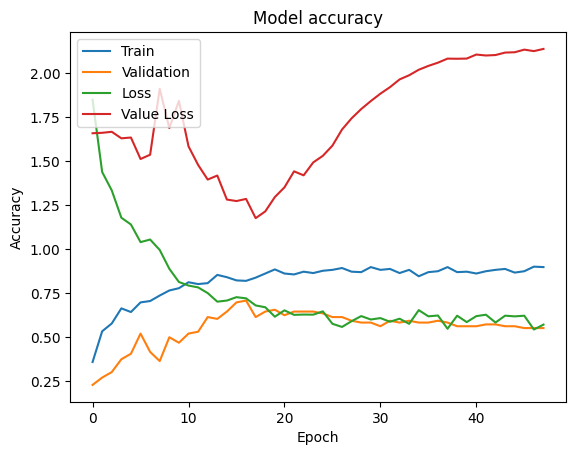

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [ ]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


6/6 [==============================] - 0s 31ms/step


# Model Visualisation (Evaluation)

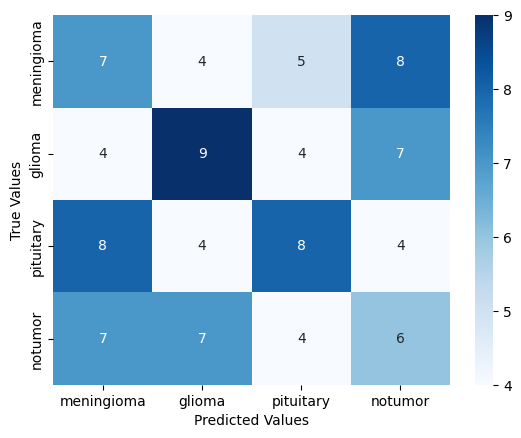

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.3138633786848073, Sensitivity: 0.3125, Specificity: 0.7708333333333334, Accuracy: 0.3125


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

def preprocess_image(img, target_size=(256, 256)):
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

def postprocess_mask(predicted_mask):
    predicted_mask = np.squeeze(predicted_mask, axis=0)
    predicted_mask = np.argmax(predicted_mask, axis=-1)
    return predicted_mask

def visualize_segmentation(original_img, predicted_mask):
    overlay = np.zeros_like(original_img, dtype=np.uint8)
    overlay[predicted_mask == 1] = 255  # Assuming class 1 is the tumor class

    alpha = 0.5
    blended_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)
    return blended_image

def segment_and_visualize_images(directory, model_path):
    # Load the trained U-Net model
    model = tf.keras.models.load_model(model_path)
    
    images = []
    masks = []
    
    # Loop over the images in the directory
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Preprocess the image
        # preprocessed_img = preprocess_image(img)
        
        # Predict the segmentation mask
        predicted_mask = model.predict(preprocessed_img)
        predicted_mask = postprocess_mask(predicted_mask)
        
        # Visualize the segmented tumor
        blended_image = visualize_segmentation(img, predicted_mask)
        
        images.append(img)
        masks.append(blended_image)
        
        if len(images) == 9:
            break
    
    # Plot the original images and their corresponding segmented masks
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    for i, (image, mask) in enumerate(zip(images, masks)):
        ax = axes[i // 3, i % 3]
        ax.imshow(mask, cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
segment_and_visualize_images(dir, model_file)